## These are the dependencies which we need to install before running this notebook.
 This notebook was run on a Conda virtual environment, so this step is added for anyone who will be running this on a virtual environment.

In [19]:
%pip install spotipy numpy networkx matplotlib scikit-learn scipy

Note: you may need to restart the kernel to use updated packages.


### Importing the required libraries

In [34]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import time
import threading
import ipywidgets as widgets
from IPython.display import display
from collections import Counter
import time
import random
import json
from sklearn.preprocessing import MinMaxScaler
from collections import deque
from spotipy.exceptions import SpotifyException

This is the authentication step with the Spotify API. This is needed to gain access to the features offered Spotify API through the web app. The process explaining how to create this web app is explained in the research paper as well.

To authenticate your web app, you need to use the Client ID and Client Secret, which is a unique identifier for that web app. Scope here defines the access we are giving to the web app over our spotify account.

In [18]:
# Spotify API credentials
SPOTIPY_CLIENT_ID = '2df1d36576ae496a9e93d0dd5c2cf65c'
SPOTIPY_CLIENT_SECRET = '1235d9815a2f4486b9611cec324ee83b'
SPOTIPY_REDIRECT_URI = 'http://localhost:3000'
SCOPE = 'playlist-read-private user-library-read user-read-playback-state user-modify-playback-state user-read-currently-playing'

# Authenticate with Spotify API
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=SPOTIPY_CLIENT_ID,
                                               client_secret=SPOTIPY_CLIENT_SECRET,
                                               redirect_uri=SPOTIPY_REDIRECT_URI,
                                               scope=SCOPE))

As mentioned in the research paper, the Spotify API puts constraints on the amount of API calls you can make in a given amount of time. To avoid hitting that limit, this function here is created. It checks if error 429 is returned by the API call, which is the code for too many API Calls. If that is the case, it stops for sometime called backoff_time in the code, and then calls the API again. If the issue still persists, then that time is multiplied by 2, each time 429 is returned again.

In [4]:
def handle_rate_limited_request(request_func, *args, **kwargs):
    retry = True
    retries = 0
    max_retries = 10  # Increase max retries
    backoff_time = 5  # Initial backoff time (seconds)
    while retry and retries < max_retries:
        try:
            response = request_func(*args, **kwargs)
            return response
        except spotipy.SpotifyException as e:
            if e.http_status == 429:
                retries += 1
                wait_time = int(e.headers.get("Retry-After", backoff_time))
                print(f"Rate limited. Retrying in {wait_time} seconds...")
                time.sleep(wait_time)
                backoff_time *= 2  # Exponential backoff
            else:
                raise e
    raise Exception("Max retries exceeded for Spotify API requests")

This function extracts audio features for tracks in batches of 100.

In [5]:
# Function to get audio features with batching and rate limiting
def get_audio_features(track_ids):
    batch_size = 100  # Maximum number of tracks per batch
    audio_features = []
    for i in range(0, len(track_ids), batch_size):
        batch = track_ids[i:i + batch_size]
        batch_features = handle_rate_limited_request(sp.audio_features, batch)
        audio_features.extend(batch_features)
    return audio_features

This function is used to extract the genres for the tracks in the playlists of the user. Spotify associates genres with the artists, so to get genres for a song, the genres of the artist of that song are extracted.

In [6]:
# Function to get all genres for tracks in a playlist
def get_genres_for_tracks(track_items, sp):
    all_genres = []
    for item in track_items:
        track = item['track']
        if track and track['id']:
            artist_id = track['artists'][0]['id']
            artist_info = sp.artist(artist_id)
            genres = artist_info.get('genres', [])
            all_genres.extend(genres)
    return all_genres

This function is used to construct the graph for the playlists present in the user's account. It uses the extracted audio features for each song to compute the cosine similarity between the songs within a playlist, and if they surpass a threshold, an edge is drawn. This threshold is adjustable in the code, to test out different configurations.

In [7]:
def create_graph_for_playlist(playlist_id, track_items, sp):
    G = nx.Graph()
    track_features = []
    scaler = MinMaxScaler()

    # Predefined set of features for cosine similarity (Based on research)
    relevant_features = ['acousticness', 'instrumentalness', 'tempo', 'energy', 'valence', 'liveness']

    # Normalisation will only be applied to 'tempo' since it is the only feature which is not normalised
    features_to_normalize = ['tempo']

    # Extracting audio features to build feature vectors based on the predefined features
    for item in track_items:
        track = item['track']
        if track and track['id']:
            features = get_audio_features([track['id']])[0]
            if features:
                feature_vector = []
                for feature in relevant_features:
                    feature_vector.append(features[feature])
                
                print(f"Feature Vector for Track {track['name']} ({track['id']}): {feature_vector}")

                artist_names = [artist['name'] for artist in track['artists']]

                track_features.append({
                    'id': track['id'],
                    'name': track['name'],
                    'artists': artist_names,
                    'feature_vector': feature_vector
                })

                G.add_node(track['id'], label=track['name'], artists=", ".join(artist_names))

    features_matrix = [track['feature_vector'] for track in track_features]
    track_ids = [track['id'] for track in track_features]

    # Converting the features_matrix to numpy array for consistent data type ; was giving an error before this fix
    features_matrix = np.array(features_matrix)

    # Normalising the 'tempo' feature only
    if 'tempo' in relevant_features:
        indices_to_normalize = [relevant_features.index(f) for f in features_to_normalize if f in relevant_features]
        features_matrix[:, indices_to_normalize] = scaler.fit_transform(features_matrix[:, indices_to_normalize])
    print(f"Normalized Features Matrix Shape: {features_matrix.shape}")

    # Check for empty or invalid feature vectors
    if features_matrix.size == 0 or features_matrix.shape[1] == 0:
        raise ValueError("Feature vectors are empty or invalid, check relevant features and extraction process.")

    # Compute similarity matrix
    similarity_matrix = cosine_similarity(features_matrix)
    print(f"Similarity Matrix Shape: {similarity_matrix.shape}")

    for i in range(len(track_ids)):
        for j in range(i + 1, len(track_ids)):
            if similarity_matrix[i, j] >= 0.95:  # Using the predefined threshold for strong similarity
                if not G.has_edge(track_ids[i], track_ids[j]):  # Ensure only one edge between nodes
                    G.add_edge(track_ids[i], track_ids[j], weight=similarity_matrix[i, j], color='blue')

    return G, track_features


This function is used to update the graph in case the user adds a new track to their playlist.

In [8]:
# Function to update the graph with a new track
def update_graph_with_new_track(graph, new_track, selected_playlist, track_features_by_playlist):
    track_id = new_track['id']

    # Predefined set of features for cosine similarity (based on research)
    relevant_features = ['acousticness', 'instrumentalness', 'tempo', 'energy', 'valence', 'liveness']

    # Extract features from the new track based on relevant features
    new_track_features = []
    for feature in relevant_features:
        new_track_features.append(new_track[feature])

    new_track_features = np.array(new_track_features)

    # Normalise the 'tempo' feature if it is part of the features
    scaler = MinMaxScaler()
    if 'tempo' in relevant_features:
        tempo_index = relevant_features.index('tempo')
        new_track_features[tempo_index] = scaler.fit_transform(new_track_features[tempo_index].reshape(-1, 1)).flatten()

    # Add the new track as a node in the graph
    graph.add_node(track_id, label=new_track['name'], artists=", ".join(new_track['artists']))

    # Compare the new track with existing nodes based on cosine similarity
    for node in graph.nodes:
        if node != track_id:
            # Get existing track's feature vector
            existing_track = next(track for track in track_features_by_playlist[selected_playlist] if track['id'] == node)
            existing_track_features = []
            for feature in relevant_features:
                existing_track_features.append(existing_track['feature_vector'][relevant_features.index(feature)])
            
            existing_track_features = np.array(existing_track_features)
            
            # Normalize the tempo feature for the existing track
            if 'tempo' in relevant_features:
                existing_track_features[tempo_index] = scaler.fit_transform(existing_track_features[tempo_index].reshape(-1, 1)).flatten()

            # Calculate cosine similarity between new and existing tracks
            similarity = cosine_similarity([new_track_features], [existing_track_features])[0, 0]
            
            # Add an edge between the tracks if they are similar enough
            if similarity >= 0.95:
                graph.add_edge(track_id, node, weight=similarity, color='blue')

In this block, the functions defined for handling API calls and creating of graphs are called.
Graph for every playlist are created and stored in a dictionary called graphs which will be used later to curate playlist according to the seed track. It will also be used to get recommendations using the Spotify API.
Another dictionary is maintain called 'track_features_by_playlist' where the playlist names are keys, and their corresponding values holds a list dictionaries, each containing information on every song such as the name, Spotify ID, artists and their feature vector in the same order as defined above in the create_graph_for_playlist function.

In [9]:
playlists = handle_rate_limited_request(sp.current_user_playlists)
graphs = {}
track_features_by_playlist = {}

for playlist in playlists['items']:
    results = handle_rate_limited_request(sp.playlist_tracks, playlist['id'])
    tracks = results['items']

    # Skip empty playlists
    if not tracks:
        continue
    
    while results['next']:
        results = handle_rate_limited_request(sp.next, results)
        tracks.extend(results['items'])

    # Ensure the necessary arguments are passed to the function
    G, track_features = create_graph_for_playlist(playlist['id'], tracks, sp)
    graphs[playlist['name']] = G
    track_features_by_playlist[playlist['name']] = track_features

Feature Vector for Track Pretty Woman (3rsx3pDYM3a08O0Yu3Tq6V): [0.124, 0.0132, 173.991, 0.942, 0.598, 0.0819]
Feature Vector for Track It's the Time to Disco (3hCUkos0NxuSFl73oOHJzb): [0.0452, 0.000129, 131.992, 0.772, 0.808, 0.12]
Feature Vector for Track Kuch To Hua Hai (0Kd2IhGYGYrOATgOOnDBzI): [0.128, 2.03e-05, 95.967, 0.661, 0.458, 0.283]
Feature Vector for Track Gori Gori Gori Gori (4RtvAfvD8lgqqBnojwaDI8): [0.0726, 0.00292, 101.009, 0.866, 0.68, 0.284]
Feature Vector for Track Ghagra (5YY8EsBdUYAg1NJQIvgCEj): [0.223, 0, 101.94, 0.919, 0.701, 0.319]
Feature Vector for Track Chittiyaan Kalaiyaan (6XjJXPP3UiGtAQpYkD01c0): [0.0962, 6.39e-05, 100.007, 0.887, 0.602, 0.623]
Feature Vector for Track Coca Cola (From "Luka Chuppi") (352wEkChkiClswqwDoM0nj): [0.121, 0.0052, 102.009, 0.867, 0.893, 0.123]
Feature Vector for Track Palat - Tera Hero Idhar Hai (From "Main Tera Hero") (0R5invf0xH2NTXVnloNRjb): [0.132, 0, 96.053, 0.729, 0.498, 0.177]
Feature Vector for Track Khwab Dekhe Sexy Lad

This block of code is used to visualise the graphs created for each playlist. You can simply change the name of the key in graphs dictionary to visualise any graph you want.

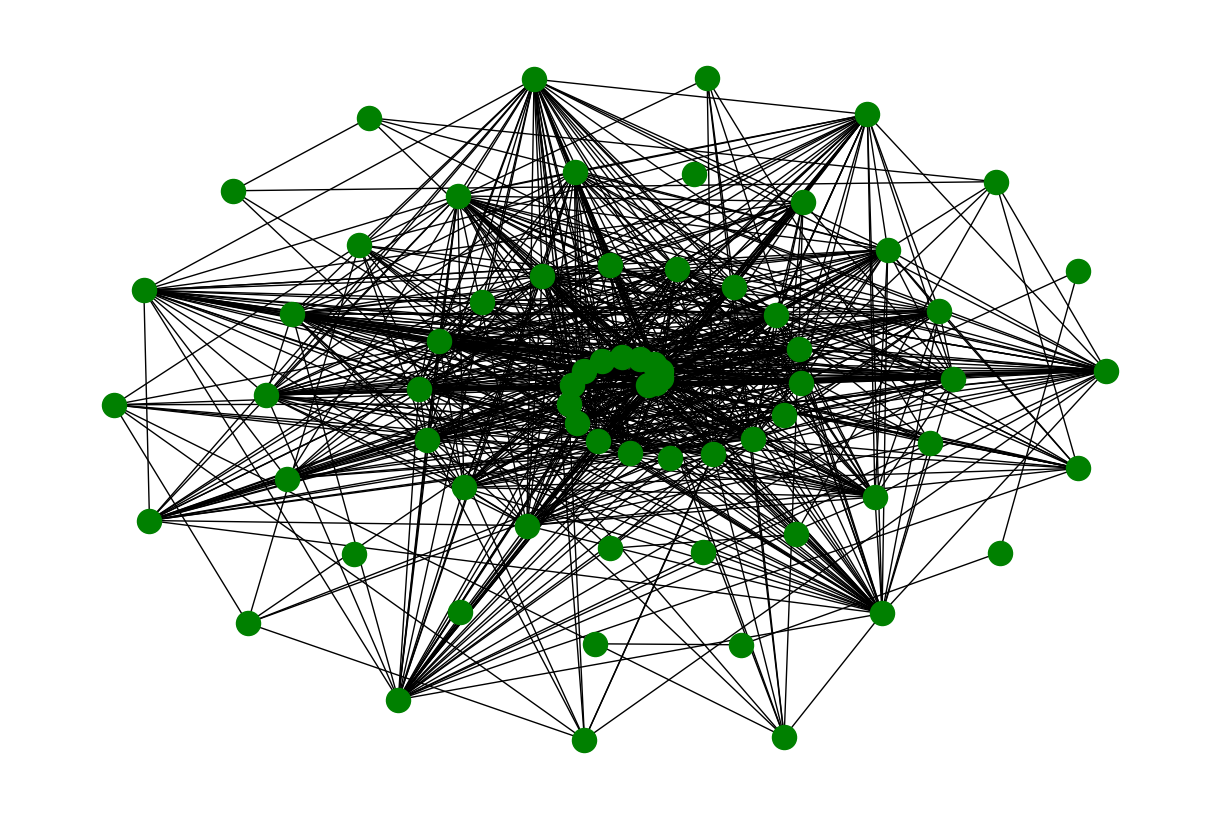

In [24]:
# Visualize the graph
Gr = graphs['⚡️']
pos = nx.spiral_layout(Gr)
edges = Gr.edges(data=True)
colors = [edge[2]['color'] for edge in edges]
weights = [edge[2]['weight'] for edge in edges]

plt.figure(figsize=(12, 8))
nx.draw(Gr, pos, node_color='green', edge_color='black', with_labels=False, labels=nx.get_node_attributes(Gr, 'label'))
plt.show()

The blocks of code below are to interact with the Get Recommendations endpoint of Spotify API.
The first block defines a dictionary, where key are the names of audio features and their values are their corresponding ranges. These ranges are defined so that the minimum and maximum value of audio features when the standard deviation is added or subtracted from target value do not exceed their defined ranges.

In [11]:
# Define acceptable ranges for audio features
FEATURE_RANGES = {
    'acousticness': (0, 1),
    'danceability': (0, 1),
    'energy': (0, 1),
    'valence': (0, 1),
    'tempo': (0, 250),
    'instrumentalness': (0, 1),
    'liveness': (0, 1),
    'loudness': (-60, 0),
    'speechiness': (0, 1)
}

This function is used to generate recommendations from a seed track from a playlist. It takes playlist name, selected track id, track_features_by_playlist dictionary, the Spotify API authenticated object 'sp' and the graph of the playlist to extract the neighbours of the seed track.
Within the function, the minimum and maximum values are also calculated for each selected audio feature. The target values are same as the values of the selected track.

In [55]:
def get_recommendations(playlist_name, selected_track_id, track_features_by_playlist, sp, graph):
    # Defining the relevant features in their order in the feature vector
    relevant_features = ['acousticness', 'instrumentalness', 'tempo', 'energy', 'valence', 'liveness']
    track_features = track_features_by_playlist[playlist_name]

    # Getting the features of the selected track
    selected_track = next((track for track in track_features if track['id'] == selected_track_id), None)

    if selected_track is None:
        print(f"Selected track ID {selected_track_id} not found in playlist {playlist_name}.")
        return []

    selected_track_vector = selected_track['feature_vector']

    # Initialising the dictionaries to store min, max, and target values
    min_values = {}
    max_values = {}
    target_values = {}

    for i, feature in enumerate(relevant_features):
        try:
            # Gathering all feature values for the current feature
            feature_values = [track['feature_vector'][i] for track in track_features]

            if not feature_values:
                print(f"Feature {feature} not found in any track in the playlist {playlist_name}.")
                continue

            # Calculate average and standard deviation for the feature
            avg = np.mean(feature_values)
            std = np.std(feature_values)

            # Calculating min and max with checks for acceptable ranges
            min_val = max(FEATURE_RANGES[feature][0], round(float(avg - std), 2))
            max_val = min(FEATURE_RANGES[feature][1], round(float(avg + std), 2))

            # Storing the min, max, and target values for this feature
            min_values[f'min_{feature}'] = min_val
            max_values[f'max_{feature}'] = max_val
            target_values[f'target_{feature}'] = round(float(selected_track_vector[i]), 2)

        except KeyError as e:
            print(f"KeyError: {e} - This feature might be missing in the track data.")
            continue

    # Getting the neighbors from the graph based on cosine similarity (edge weights)
    neighbors = sorted(graph[selected_track_id], key=lambda x: graph[selected_track_id][x]['weight'], reverse=True)

    # Handling cases where fewer than 4 neighbors are found, this is important as there might be a case the user calls this function on a node with
    # less than 4 neighbours or it might be a disconnected component in the graph.
    all_neighbors = neighbors[:4]
    if len(all_neighbors) < 4:
        for neighbor in neighbors:
            next_neighbors = sorted(graph[neighbor], key=lambda x: graph[neighbor][x]['weight'], reverse=True)
            for next_neighbor in next_neighbors:
                if next_neighbor not in all_neighbors and next_neighbor != selected_track_id:
                    all_neighbors.append(next_neighbor)
                    if len(all_neighbors) == 4:
                        break
            if len(all_neighbors) == 4:
                break

    # Using the selected track as the seed if no neighbors are found
    if not all_neighbors:
        seed_tracks = [selected_track_id]
    else:
        seed_tracks = [selected_track_id] + all_neighbors[:3]

    # Deduplicating and limit to 5 seeds
    seed_tracks = list(set(seed_tracks))[:5]

    try:
        # Generating recommendations from Spotify API by harnessing the graph structure and audio features.
        recommendations = sp.recommendations(
            limit=5,
            market='GB',
            seed_tracks=seed_tracks[:5],  # Ensuring no more than 5 seed tracks, otherwise Spotify API will throw an error
            **min_values,
            **max_values,
            **target_values
        )
        return recommendations['tracks']
    except spotipy.exceptions.SpotifyException as e:
        print(f"Error: {e}")
        return []

Now this is the block where all the dots connect. This large block of code is responsible for creation of interactive dashboard, queuing of songs through graph traversal from the chosen node, and also provides options to get recommendation for the chosen song, based on the graph structure and audio features.

In [56]:
# The set that keeps track of the nodes that have been traversed.
played_and_queued_tracks = set()

# Function to get the device ID of the first available device, this can be your mobile if the Spotify app is open on it.
def get_device_id():
    devices = sp.devices()
    if devices['devices']:
        return devices['devices'][0]['id']
    return None

device_id = get_device_id()

# Function to play a track
def play_track(track_id):
    sp.start_playback(device_id=device_id, uris=[f'spotify:track:{track_id}'])

def queue_track(track_id):
    # Ensure the track_id is correctly formatted
    uri = f'spotify:track:{track_id}'
    try:
        sp.add_to_queue(uri, device_id)
    except SpotifyException as e:
        print(f"Failed to queue track {track_id}: {e}")

# DFS Function to Traverse the Graph
def dfs_queue(graph, current_track_id):
    """Performs DFS starting from the current_track_id and queues tracks."""
    stack = [current_track_id]
    
    while stack:
        node = stack.pop()
        
        # Skip any tracks that have already been played or queued
        if node in played_and_queued_tracks:
            continue
        
        # Queue the next valid track and update the set
        queue_track(node)
        played_and_queued_tracks.add(node)
        
        # Check if all tracks have been traversed
        if len(played_and_queued_tracks) == len(graph.nodes):
            print("All songs have been traversed. Ending traversal.")
            return
        
        # Add neighbors to the stack for further DFS, excluding already visited nodes
        neighbors = sorted(graph[node], key=lambda x: graph[node][x]['weight'], reverse=True)
        stack.extend(neighbor for neighbor in neighbors if neighbor not in played_and_queued_tracks)

def bfs_find_unvisited(graph, start_node):
    visited = set()
    queue = deque([start_node])

    while queue:
        node = queue.popleft()
        
        if node not in played_and_queued_tracks:
            return node
        
        visited.add(node)
        neighbors = sorted(graph[node], key=lambda x: graph[node][x]['weight'], reverse=True)
        queue.extend(neighbor for neighbor in neighbors if neighbor not in visited)

    return None  # If no unvisited node is found

def find_most_similar_node(graph, current_node, track_features):
    current_features = np.array(track_features[current_node]['feature_vector'])
    max_similarity = -1
    most_similar_node = None

    for track_id, features in track_features.items():
        if track_id not in played_and_queued_tracks:
            similarity = cosine_similarity([current_features], [np.array(features['feature_vector'])])[0, 0]
            if similarity > max_similarity:
                max_similarity = similarity
                most_similar_node = track_id

    return most_similar_node

def display_recommendations():
    """Displays recommendations as buttons, allowing users to queue songs on their device."""
    track_id = track_dropdown.value
    playlist_name = playlist_dropdown.value
    selected_graph = graphs[playlist_name]

    recommendations = get_recommendations(playlist_name, track_id, track_features_by_playlist, sp, selected_graph)

    with output:
        output.clear_output()  # Clear previous outputs
        if not recommendations:
            print("No recommendations found.")
            return

        for track in recommendations:
            # Create a button for each recommended track
            track_button = widgets.Button(
                description=f"Queue {track['name']} by {', '.join([artist['name'] for artist in track['artists']])}",
                layout=widgets.Layout(width='600px', height='50px')  # Set button size
            )
            track_button.on_click(lambda b, t=track: queue_track(t['id']))  # Queue the track when button is clicked
            display(track_button)


def queue_next_track(starting_track_id):
    global played_and_queued_tracks, playlist

    selected_playlist = playlist_dropdown.value
    selected_graph = graphs[selected_playlist]

    # Ensure the starting track is marked as traversed
    played_and_queued_tracks.add(starting_track_id)

    # Traverse and queue tracks using DFS
    dfs_queue(selected_graph, starting_track_id)

    # If DFS traversal doesn't cover all nodes, use BFS
    while len(played_and_queued_tracks) < len(selected_graph.nodes):
        next_track_id = bfs_find_unvisited(selected_graph, starting_track_id)
        if next_track_id:
            dfs_queue(selected_graph, next_track_id)
        else:
            break

    # If BFS also fails to find unvisited nodes, fallback to cosine similarity
    if len(played_and_queued_tracks) < len(playlist):
        unvisited_tracks = [track for track in playlist if track['id'] not in played_and_queued_tracks]
        if unvisited_tracks:
            most_similar_track_id = find_most_similar_node(selected_graph, starting_track_id, track_features_by_playlist[selected_playlist])
            if most_similar_track_id:
                dfs_queue(selected_graph, most_similar_track_id)


# Function to clear the queue
def clear_queue():
    global played_and_queued_tracks
    played_and_queued_tracks.clear()
    sp.pause_playback(device_id=device_id)  # Pause playback to clear queue
    with output:
        print("Queue cleared.")

# Function to start graph traversal immediately after a track is played
def on_play_button_clicked_immediate(b):
    with output:
        track_id = track_dropdown.value
        if track_id:
            play_track(track_id)
            queue_next_track(track_id)  # Pass the selected track to the traversal function
        else:
            print("Please select a track first.")

# Creation of widgets for playlist and track selection
playlist_dropdown = widgets.Dropdown(options=list(graphs.keys()), description='Playlist:')
track_dropdown = widgets.Dropdown(description='Tracks:')
play_button = widgets.Button(description="Play")
pause_button = widgets.Button(description="Pause")
recommend_button = widgets.Button(description="Get Recommendations")
clear_queue_button = widgets.Button(description="Clear Queue")
output = widgets.Output()

# Event handlers for buttons
def on_pause_button_clicked(b):
    with output:
        sp.pause_playback(device_id=device_id)


def on_clear_queue_button_clicked(b):
    with output:
        clear_queue()

recommend_button = widgets.Button(
    description="Get Recommendations",
    layout=widgets.Layout(width='300px', height='40px')
)

play_button = widgets.Button(
    description="Play",
    layout=widgets.Layout(width='300px', height='40px')  # Adjust width and height as desired
)

pause_button = widgets.Button(
    description="Pause",
    layout=widgets.Layout(width='300px', height='40px')  # Adjust width and height as desired
)

clear_queue_button = widgets.Button(
    description="Clear Queue",
    layout=widgets.Layout(width='300px', height='40px')  # Adjust width and height as desired
)

def update_track_dropdown(change):
    selected_playlist = change['new']
    track_items = graphs[selected_playlist].nodes
    track_dropdown.options = [(track['label'], track_id) for track_id, track in track_items.items()]


def on_recommend_button_clicked(b):
    display_recommendations()


# Link the playlist dropdown to the track dropdown update
playlist_dropdown.observe(update_track_dropdown, names='value')

# Assign event handlers to buttons
play_button.on_click(on_play_button_clicked_immediate)
pause_button.on_click(on_pause_button_clicked)
recommend_button.on_click(on_recommend_button_clicked)
clear_queue_button.on_click(on_clear_queue_button_clicked)

# Display widgets
display(playlist_dropdown, track_dropdown, play_button, pause_button, recommend_button, clear_queue_button, output)

Dropdown(description='Playlist:', options=('Bollywood Mixed', '⚡️', '👺🔥', '❤️🥤', '⭐️', "'Cause I'm a fool for …

Dropdown(description='Tracks:', options=(), value=None)

Button(description='Play', layout=Layout(height='40px', width='300px'), style=ButtonStyle())

Button(description='Pause', layout=Layout(height='40px', width='300px'), style=ButtonStyle())

Button(description='Get Recommendations', layout=Layout(height='40px', width='300px'), style=ButtonStyle())

Button(description='Clear Queue', layout=Layout(height='40px', width='300px'), style=ButtonStyle())

Output()